In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 100)

import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

dir_path = "/kaggle/input/commonlit-evaluate-student-summaries/"

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/commonlit-evaluate-student-summaries/sample_submission.csv
/kaggle/input/commonlit-evaluate-student-summaries/prompts_train.csv
/kaggle/input/commonlit-evaluate-student-summaries/summaries_test.csv
/kaggle/input/commonlit-evaluate-student-summaries/summaries_train.csv
/kaggle/input/commonlit-evaluate-student-summaries/prompts_test.csv


# CommonLit-Evaluate Student Summaries

In [2]:
# Load the datasets
df_prompts_train = pd.read_csv(dir_path + 'prompts_train.csv')
df_prompts_test = pd.read_csv(dir_path + 'prompts_test.csv')
df_train = pd.read_csv(dir_path + 'summaries_train.csv')
df_test = pd.read_csv(dir_path + 'summaries_test.csv')
df_sample_submission = pd.read_csv(dir_path + 'sample_submission.csv')

In [3]:
# Display the first few rows of each dataset
print('df_prompts_train')
print(df_prompts_train.info()) 
print('df_prompts_test')
print(df_prompts_test.info())
print('df_train')
print(df_train.info())
print('df_test')
print(df_test.info())
print('df_sample_submission')
print(df_sample_submission.info())

df_prompts_train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   prompt_id        4 non-null      object
 1   prompt_question  4 non-null      object
 2   prompt_title     4 non-null      object
 3   prompt_text      4 non-null      object
dtypes: object(4)
memory usage: 256.0+ bytes
None
df_prompts_test
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   prompt_id        2 non-null      object
 1   prompt_question  2 non-null      object
 2   prompt_title     2 non-null      object
 3   prompt_text      2 non-null      object
dtypes: object(4)
memory usage: 192.0+ bytes
None
df_train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7165 entries, 0 to 7164
Data columns (total 5 columns):
 #   Column 

In [4]:
# Check for missing values
print(df_train.isnull().sum())
print()
print(df_test.isnull().sum())

student_id    0
prompt_id     0
text          0
content       0
wording       0
dtype: int64

student_id    0
prompt_id     0
text          0
dtype: int64


In [5]:
#temp

# df_prompts_train= df_prompts_train.iloc[:10,:]
# df_prompts_test = df_prompts_test.iloc[:10,:]
# df_train = df_train.iloc[:10,:]
# df_test = df_test.iloc[:10,:]
# df_sample_submission = df_sample_submission.iloc[:10,:]

In [6]:
df_train['source'] = 'train'
df_test['source'] = 'test'

df_prompts_train['source'] = 'train'
df_prompts_test['source'] = 'test'

df_train_test_merged = pd.concat([df_train, df_test], ignore_index=True)
df_prompts_merged = pd.concat([df_prompts_train, df_prompts_test], ignore_index=True)

# Feature Engineering
# 1. Text Length & Unique Words
df_train_test_merged['summary_length'] = df_train_test_merged['text'].apply(len)
df_train_test_merged['num_words'] = df_train_test_merged['text'].apply(lambda x: len((x.split())))
df_train_test_merged['unique_words'] = df_train_test_merged['text'].apply(lambda x: len(set(x.split())))

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# 2. TF-IDF Vectorization & Cosine Similarity with the prompt
# Assuming df_prompts_train is loaded and contains the prompts
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df_train_test_merged['text'])
tfidf_matrix_prompts = tfidf_vectorizer.transform(df_prompts_merged['prompt_text'])

# Merge DataFrames with suffixes to differentiate same-named columns
df_train_test_merged = df_train_test_merged.merge(df_prompts_merged, on=['prompt_id','source'], suffixes=('', '_drop'))

# Create composite reference texts
df_train_test_merged['composite_prompt'] = df_train_test_merged['prompt_question'] + ' ' + df_train_test_merged['prompt_title'] + ' ' + df_train_test_merged['prompt_text']

# Compute cosine similarity for each entry with its corresponding prompt
cosine_sim_values = []
for index, row in df_train_test_merged.iterrows():
    summary_vec = tfidf_vectorizer.transform([row['text']])
    prompt_vec = tfidf_vectorizer.transform([row['prompt_text']])
    cosine_sim_value = cosine_similarity(summary_vec, prompt_vec)[0][0]
    cosine_sim_values.append(cosine_sim_value)

df_train_test_merged['cosine_similarity'] = cosine_sim_values

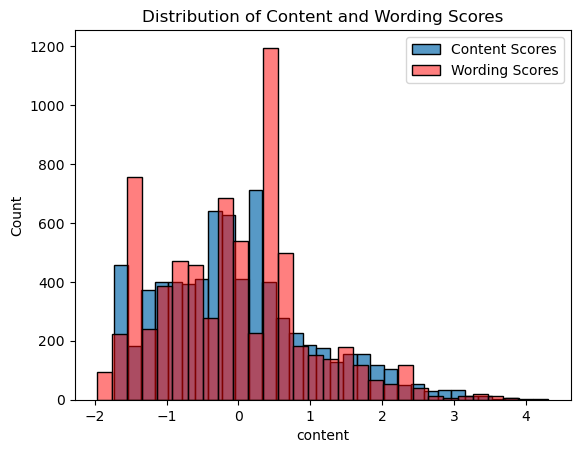

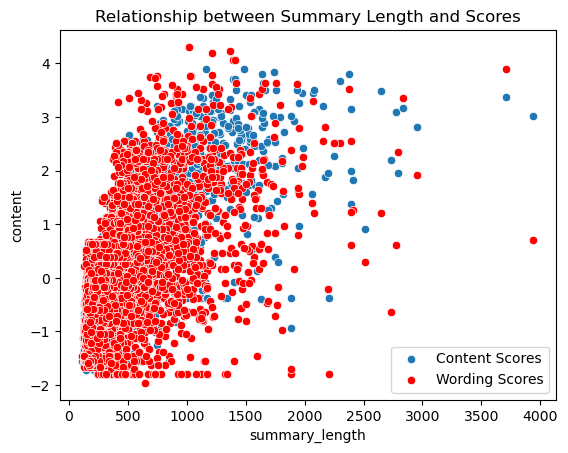

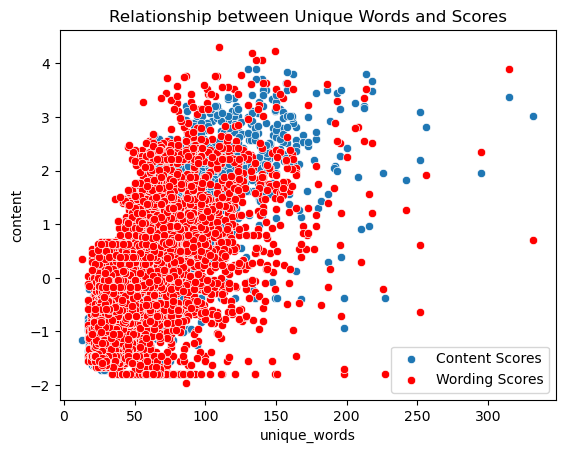

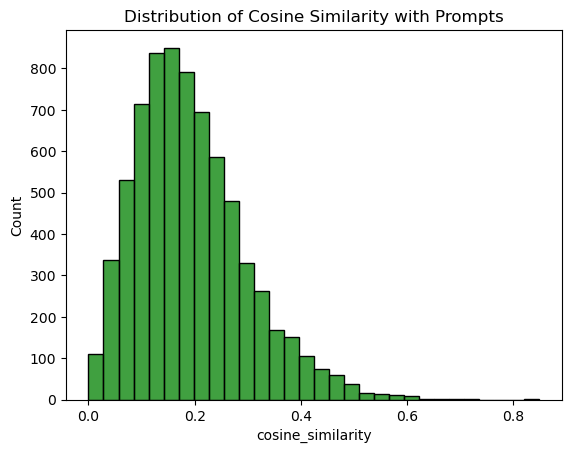

In [8]:
# This code provides insights into the data distribution, relationships between features, and scores.
# Visualization

# 1. Distribution of content and wording scores
#plt.figure(figsize=(12, 6))
sns.histplot(df_train_test_merged['content'], bins=30, label='Content Scores')
sns.histplot(df_train_test_merged['wording'], bins=30, label='Wording Scores', color='red', alpha=0.5)
plt.title('Distribution of Content and Wording Scores')
plt.legend()
plt.show()

# 2. Relationship between summary length and scores
#plt.figure(figsize=(12, 6))
sns.scatterplot(x=df_train_test_merged['summary_length'], y=df_train_test_merged['content'], label='Content Scores')
sns.scatterplot(x=df_train_test_merged['summary_length'], y=df_train_test_merged['wording'], label='Wording Scores', color='red')
plt.title('Relationship between Summary Length and Scores')
plt.legend()
plt.show()

# 3. Relationship between unique words and scores
#plt.figure(figsize=(12, 6))
sns.scatterplot(x=df_train_test_merged['unique_words'], y=df_train_test_merged['content'], label='Content Scores')
sns.scatterplot(x=df_train_test_merged['unique_words'], y=df_train_test_merged['wording'], label='Wording Scores', color='red')
plt.title('Relationship between Unique Words and Scores')
plt.legend()
plt.show()

# 4. Distribution of cosine similarity
#plt.figure(figsize=(12, 6))
sns.histplot(df_train_test_merged['cosine_similarity'], bins=30, color='green')
plt.title('Distribution of Cosine Similarity with Prompts')
plt.show()

In [9]:
# Apply log transformation to the skewed features
# df_train_test_merged['log_summary_length'] = np.log1p(df_train_test_merged['summary_length'])
# df_train_test_merged['log_unique_words'] = np.log1p(df_train_test_merged['unique_words'])

## Exploring scoring algorithms

In [10]:
pip install rouge

Note: you may need to restart the kernel to use updated packages.


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
from scipy.spatial.distance import jaccard

# Drop the duplicate columns with '_drop' suffix
for col in df_train_test_merged.columns:
    if col.endswith('_drop'):
        df_train_test_merged.drop(columns=[col], inplace=True)

# Implement Scoring Metrics
def calc_cosine_similarity(text1, text2):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform([text1, text2])
    return cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]

def calc_bleu(text, reference):
    return sentence_bleu([reference.split()], text.split())

def calc_rouge(text, reference):
    rouge = Rouge()
    scores = rouge.get_scores(text, reference)
    return scores[0]['rouge-1']['f']

def calc_rouge_extended(text, reference):
    try:
        rouge = Rouge()
        scores = rouge.get_scores(text, reference)
        
        rouge_1_f1 = scores[0]['rouge-1']['f']
        rouge_2_f1 = scores[0]['rouge-2']['f']
        rouge_L_f1 = scores[0]['rouge-l']['f']
        
        return rouge_1_f1, rouge_2_f1, rouge_L_f1
    
    except Exception as e:
        print(f"An error occurred while calculating ROUGE: {e}")
        return 0, 0, 0

def calc_jaccard_1 (text1, text2):
    set1, set2 = set(text1.split()), set(text2.split())
    return 1 - jaccard(set1, set2)

def calc_jaccard(text1, text2):
    set1, set2 = set(text1.split()), set(text2.split())
    intersection = len(set1.intersection(set2))
    union = len(set1) + len(set2) - intersection
    return intersection / float(union) if union != 0 else 0

In [12]:
# Calculate Scores - prompt-text
df_train_test_merged['cosine_text'] = df_train_test_merged.apply(lambda row: calc_cosine_similarity(row['text'], row['prompt_text']), axis=1)
df_train_test_merged['bleu_text'] = df_train_test_merged.apply(lambda row: calc_bleu(row['text'], row['prompt_text']), axis=1)
df_train_test_merged['jaccard_text'] = df_train_test_merged.apply(lambda row: calc_jaccard(row['text'], row['prompt_text']), axis=1)
# df_train_merged['rouge_text'] = df_train_merged.apply(lambda row: calc_rouge(row['text'], row['prompt_text']), axis=1)
# df_train_merged[['rouge_text1','rouge_text2','rouge_textL']] = df_train_merged.apply(lambda row: calc_rouge_extended(row['text'], row['prompt_text']), axis=1)

# Store the tuples in a new column
df_train_test_merged['rouge_tuple'] = df_train_test_merged.apply(lambda row: calc_rouge_extended(row['text'], row['prompt_text']), axis=1)
# Split the tuple into separate columns
df_train_test_merged[['rouge_text1', 'rouge_text2', 'rouge_textL']] = pd.DataFrame(df_train_test_merged['rouge_tuple'].tolist(), index=df_train_test_merged.index)
# Optionally, drop the temporary 'rouge_tuple' column
df_train_test_merged.drop(columns=['rouge_tuple'], inplace=True)

In [13]:
# Calculate Scores - prompt-title
df_train_test_merged['cosine_title'] = df_train_test_merged.apply(lambda row: calc_cosine_similarity(row['text'], row['prompt_title']), axis=1)
df_train_test_merged['bleu_title'] = df_train_test_merged.apply(lambda row: calc_bleu(row['text'], row['prompt_title']), axis=1)
df_train_test_merged['jaccard_title'] = df_train_test_merged.apply(lambda row: calc_jaccard(row['text'], row['prompt_title']), axis=1)
# df_train_merged['rouge_title'] = df_train_merged.apply(lambda row: calc_rouge(row['text'], row['prompt_title']), axis=1)
# df_train_merged[['rouge_title1','rouge_title2','rouge_titleL']] = df_train_merged.apply(lambda row: calc_rouge_extended(row['text'], row['prompt_title']), axis=1)

# Store the tuples in a new column
df_train_test_merged['rouge_tuple'] = df_train_test_merged.apply(lambda row: calc_rouge_extended(row['text'], row['prompt_title']), axis=1)
# Split the tuple into separate columns
df_train_test_merged[['rouge_title1', 'rouge_title2', 'rouge_titleL']] = pd.DataFrame(df_train_test_merged['rouge_tuple'].tolist(), index=df_train_test_merged.index)
# Optionally, drop the temporary 'rouge_tuple' column
df_train_test_merged.drop(columns=['rouge_tuple'], inplace=True)

In [14]:
# Calculate Scores - prompt-question
df_train_test_merged['cosine_question'] = df_train_test_merged.apply(lambda row: calc_cosine_similarity(row['text'], row['prompt_question']), axis=1)
df_train_test_merged['bleu_question'] = df_train_test_merged.apply(lambda row: calc_bleu(row['text'], row['prompt_question']), axis=1)
df_train_test_merged['jaccard_question'] = df_train_test_merged.apply(lambda row: calc_jaccard(row['text'], row['prompt_question']), axis=1)
# df_train_merged['rouge_question'] = df_train_merged.apply(lambda row: calc_rouge(row['text'], row['prompt_question']), axis=1)
# df_train_merged[['rouge_question1','rouge_question2','rouge_questionL']] = df_train_merged.apply(lambda row: calc_rouge_extended(row['text'], row['prompt_question']), axis=1)

# Store the tuples in a new column
df_train_test_merged['rouge_tuple'] = df_train_test_merged.apply(lambda row: calc_rouge_extended(row['text'], row['prompt_question']), axis=1)
# Split the tuple into separate columns
df_train_test_merged[['rouge_question1','rouge_question2','rouge_questionL']] = pd.DataFrame(df_train_test_merged['rouge_tuple'].tolist(), index=df_train_test_merged.index)
# Optionally, drop the temporary 'rouge_tuple' column
df_train_test_merged.drop(columns=['rouge_tuple'], inplace=True)

In [15]:

# Calculate Scores against composite_prompt
df_train_test_merged['cosine_composite'] = df_train_test_merged.apply(lambda row: calc_cosine_similarity(row['text'], row['composite_prompt']), axis=1)
df_train_test_merged['bleu_composite'] = df_train_test_merged.apply(lambda row: calc_bleu(row['text'], row['composite_prompt']), axis=1)
df_train_test_merged['jaccard_composite'] = df_train_test_merged.apply(lambda row: calc_jaccard(row['text'], row['composite_prompt']), axis=1)
# df_train_merged['rouge_composite'] = df_train_merged.apply(lambda row: calc_rouge(row['text'], row['composite_prompt']), axis=1)
# df_train_merged[['rouge_composite1','rouge_composite2','rouge_compositeL']] = df_train_merged.apply(lambda row: calc_rouge_extended(row['text'], row['composite_prompt']), axis=1)

# Store the tuples in a new column
df_train_test_merged['rouge_tuple'] = df_train_test_merged.apply(lambda row: calc_rouge_extended(row['text'], row['composite_prompt']), axis=1)
# Split the tuple into separate columns
df_train_test_merged[['rouge_composite1','rouge_composite2','rouge_compositeL']] = pd.DataFrame(df_train_test_merged['rouge_tuple'].tolist(), index=df_train_test_merged.index)
# Optionally, drop the temporary 'rouge_tuple' column
df_train_test_merged.drop(columns=['rouge_tuple'], inplace=True)

In [16]:
print("df_train_test_merged")
print(df_train_test_merged.info())

df_train_test_merged
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7169 entries, 0 to 7168
Data columns (total 38 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   student_id         7169 non-null   object 
 1   prompt_id          7169 non-null   object 
 2   text               7169 non-null   object 
 3   content            7165 non-null   float64
 4   wording            7165 non-null   float64
 5   source             7169 non-null   object 
 6   summary_length     7169 non-null   int64  
 7   num_words          7169 non-null   int64  
 8   unique_words       7169 non-null   int64  
 9   prompt_question    7169 non-null   object 
 10  prompt_title       7169 non-null   object 
 11  prompt_text        7169 non-null   object 
 12  composite_prompt   7169 non-null   object 
 13  cosine_similarity  7169 non-null   float64
 14  cosine_text        7169 non-null   float64
 15  bleu_text          7169 non-null   float64
 16  jac

In [17]:
df_train_merged = df_train_test_merged[df_train_test_merged['source'] == 'train']
df_test_merged = df_train_test_merged[df_train_test_merged['source'] == 'test']

## EDA

In [18]:
statistical_summary  = df_train_merged.describe()
statistical_summary

,content,wording,summary_length,num_words,unique_words,cosine_similarity,cosine_text,bleu_text,jaccard_text,rouge_text1,rouge_text2,rouge_textL,cosine_title,bleu_title,jaccard_title,rouge_title1,rouge_title2,rouge_titleL,cosine_question,bleu_question,jaccard_question,rouge_question1,rouge_question2,rouge_questionL,cosine_composite,bleu_composite,jaccard_composite,rouge_composite1,rouge_composite2,rouge_compositeL
count,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7.165000e+03,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7.165000e+03,7165.000000,7165.000000,7165.000000,7165.000000
mean,-0.014853,-0.063072,418.776971,74.811724,52.145569,0.192588,0.533432,4.696497e-03,0.088839,0.167627,0.063041,0.159148,0.106043,0.098511,0.009266,0.018095,0.003689,0.017943,0.230268,0.280770,0.089429,0.175411,0.045965,0.155197,0.541174,4.209854e-03,0.089897,0.169824,0.065745,0.161845
std,1.043569,1.036048,307.833685,53.503992,29.510068,0.104388,0.149744,2.196352e-02,0.049987,0.080773,0.065939,0.079979,0.094524,0.154069,0.017363,0.033054,0.015710,0.032875,0.120379,0.198201,0.054385,0.093525,0.061763,0.086397,0.149888,2.046195e-02,0.049345,0.080065,0.064670,0.079090
min,-1.729859,-1.962614,114.000000,22.000000,13.000000,0.000000,0.066190,8.388821e-19,0.014793,0.031891,0.000000,0.024096,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070418,3.223212e-19,0.014368,0.031111,0.000000,0.026667
25%,-0.799545,-0.872720,216.000000,39.000000,31.000000,0.116680,0.429899,3.656799e-08,0.055195,0.111437,0.020270,0.104046,0.038548,0.000000,0.000000,0.000000,0.000000,0.000000,0.135847,0.105051,0.052632,0.111111,0.000000,0.097561,0.438269,2.036478e-08,0.056604,0.113636,0.023179,0.107143
50%,-0.093814,-0.081769,320.000000,58.000000,44.000000,0.177101,0.542328,9.331599e-06,0.076471,0.149254,0.039216,0.141328,0.083325,0.000000,0.000000,0.000000,0.000000,0.000000,0.230039,0.222913,0.079646,0.163265,0.027586,0.142857,0.551440,6.086346e-06,0.077882,0.152113,0.043993,0.144509
75%,0.499660,0.503833,513.000000,92.000000,63.000000,0.250353,0.641635,4.976642e-04,0.107930,0.203753,0.084444,0.194553,0.148876,0.270060,0.014493,0.029412,0.000000,0.028986,0.318650,0.472871,0.113924,0.222222,0.064516,0.197183,0.650592,3.614771e-04,0.109091,0.207317,0.086768,0.198095
max,3.900326,4.310693,3940.000000,647.000000,332.000000,0.848759,0.941448,5.791747e-01,0.700935,0.833962,0.798133,0.833962,0.562069,0.521695,0.142857,0.260870,0.148148,0.260870,0.634514,0.747674,0.481481,0.717949,0.500000,0.717949,0.934659,5.328664e-01,0.673653,0.813996,0.772881,0.813996


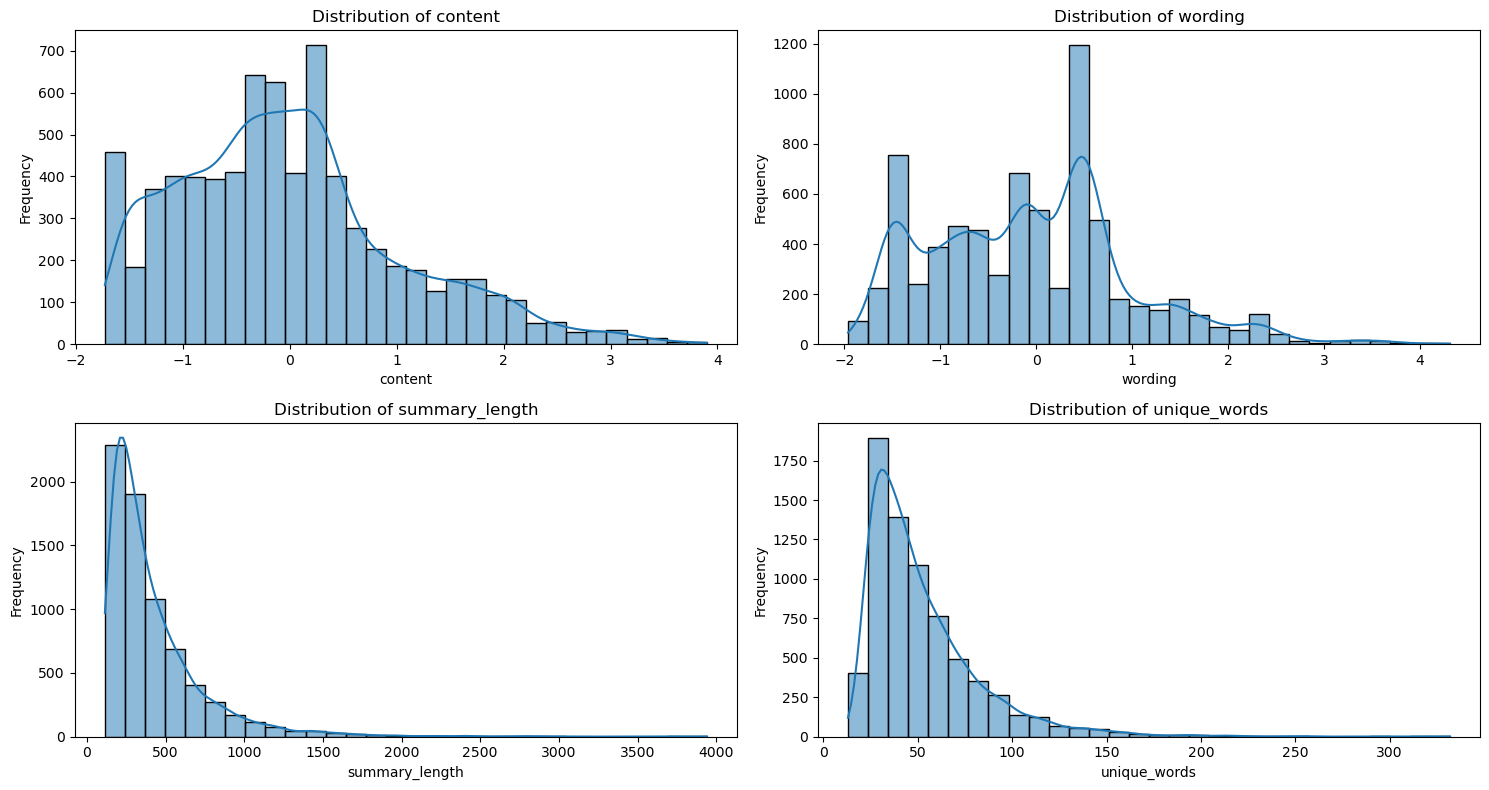

In [19]:
# Set up the matplotlib figure
plt.figure(figsize=(15, 8))

# Define the key features and target variables to visualize
key_features = ['content', 'wording', 'summary_length', 'unique_words']
target_variables = ['content', 'wording']

# Plot distributions of key features and target variables
for i, feature in enumerate(key_features):
    plt.subplot(2, 2, i+1)
    sns.histplot(df_train_merged[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

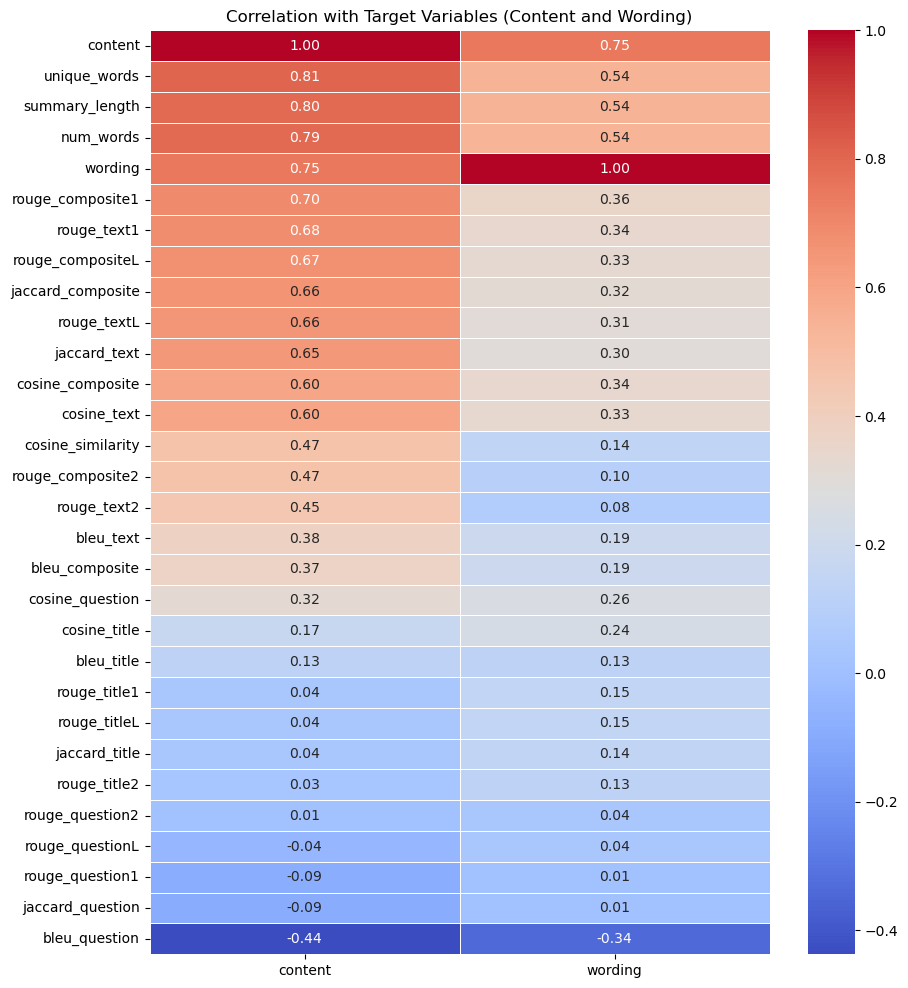

In [20]:
# Calculate the correlation matrix
correlation_matrix = df_train_merged.corr()

# Focus on how features correlate with the target variables 'content' and 'wording'
correlation_with_target = correlation_matrix.loc[:, ['content', 'wording']].sort_values(by='content', ascending=False)

# Plot the correlations
plt.figure(figsize=(10, 12))
sns.heatmap(correlation_with_target, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation with Target Variables (Content and Wording)')
plt.show()


<Figure size 1500x800 with 0 Axes>

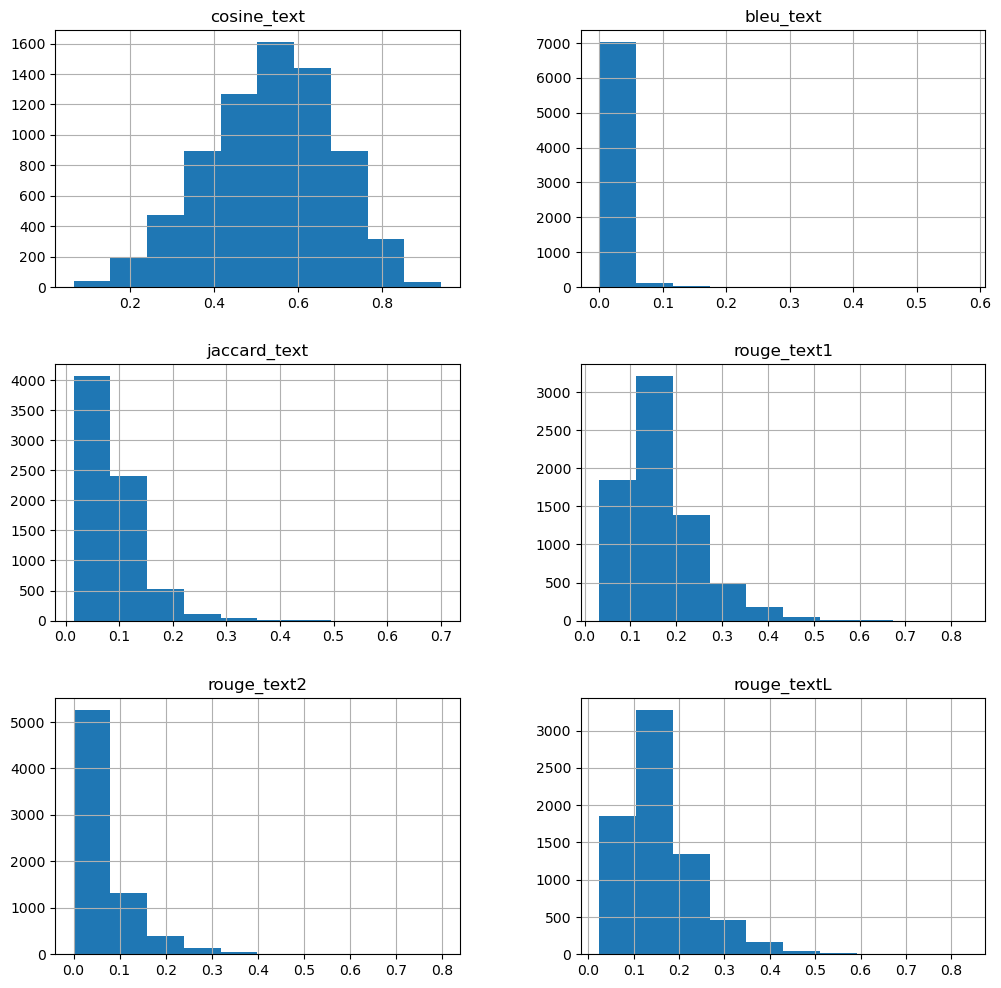

In [21]:
plt.figure(figsize=(15, 8))
df_train_merged[df_train_merged.filter(regex='_text').columns].hist(figsize=(12, 12))
plt.show()


<Figure size 1500x800 with 0 Axes>

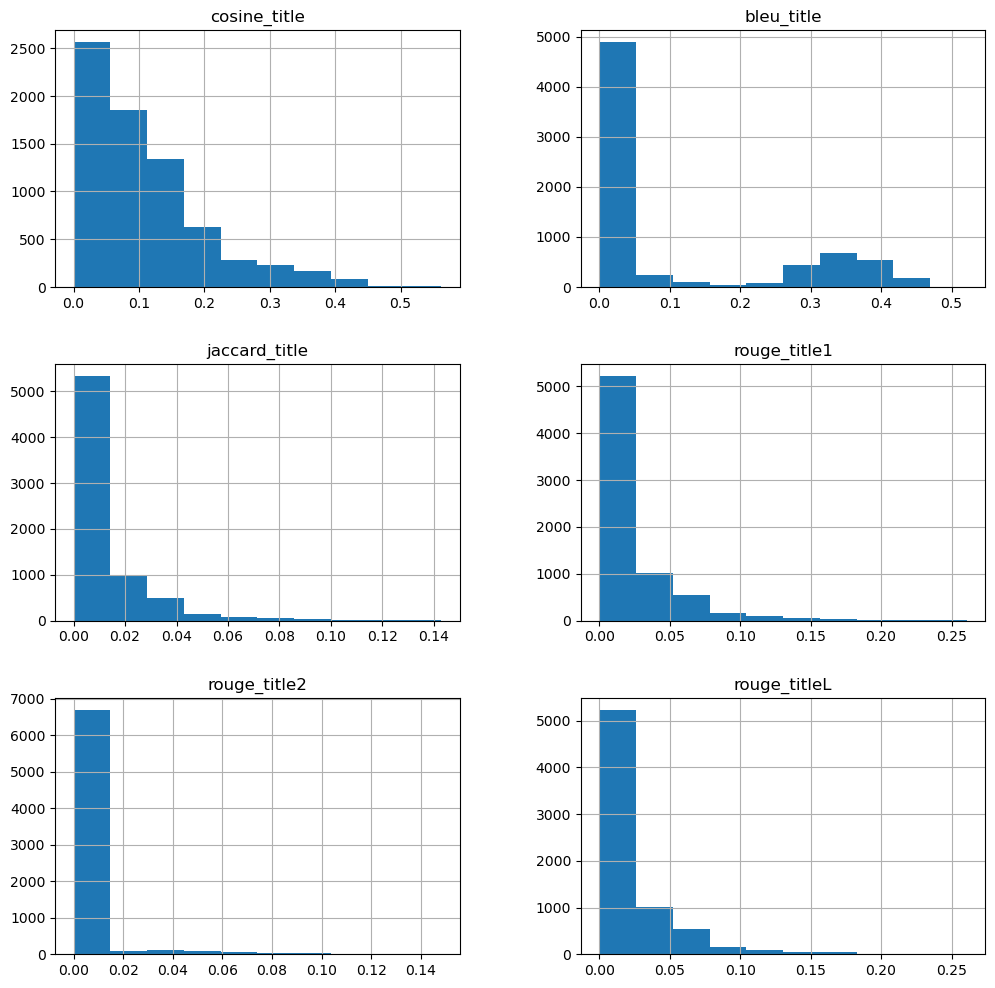

In [22]:
plt.figure(figsize=(15, 8))
df_train_merged[df_train_merged.filter(regex='_title').columns].hist(figsize=(12, 12))
plt.show()


<Figure size 1500x800 with 0 Axes>

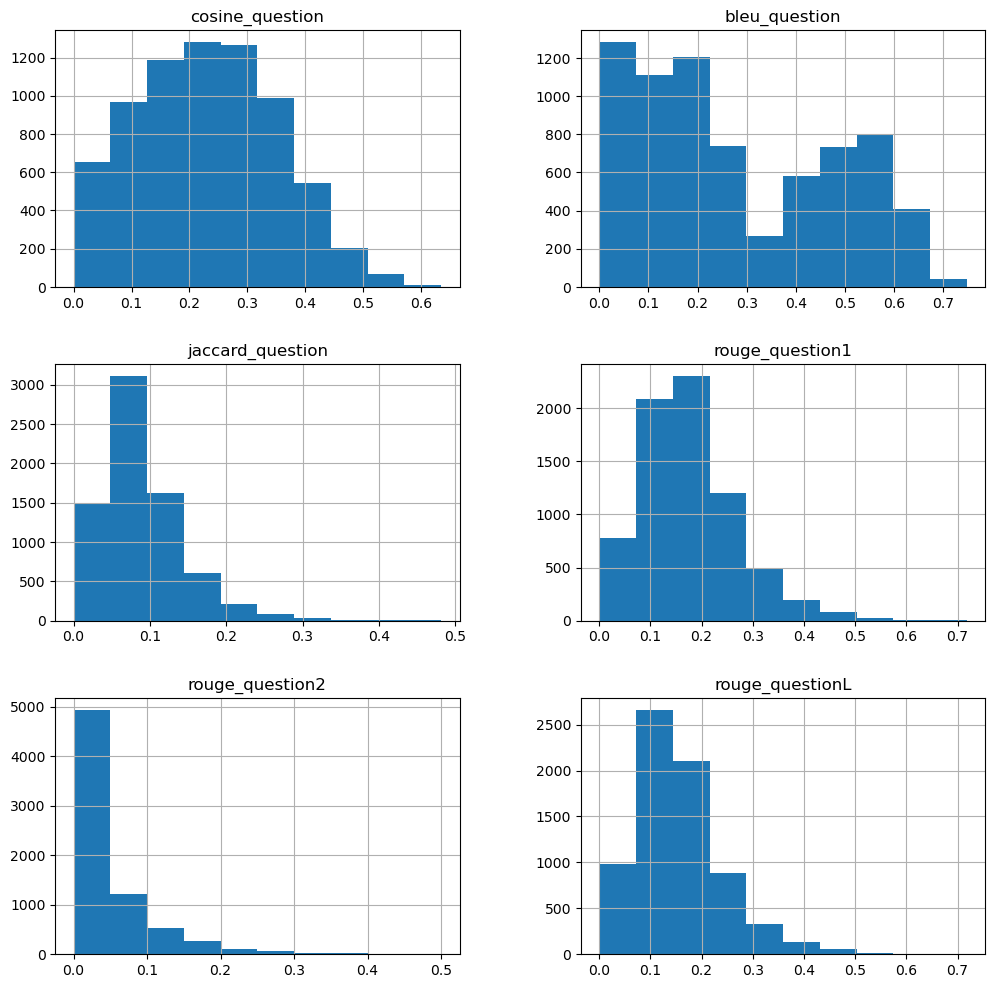

In [23]:
plt.figure(figsize=(15, 8))
df_train_merged[df_train_merged.filter(regex='_question').columns].hist(figsize=(12, 12))
plt.show()

<Figure size 1500x800 with 0 Axes>

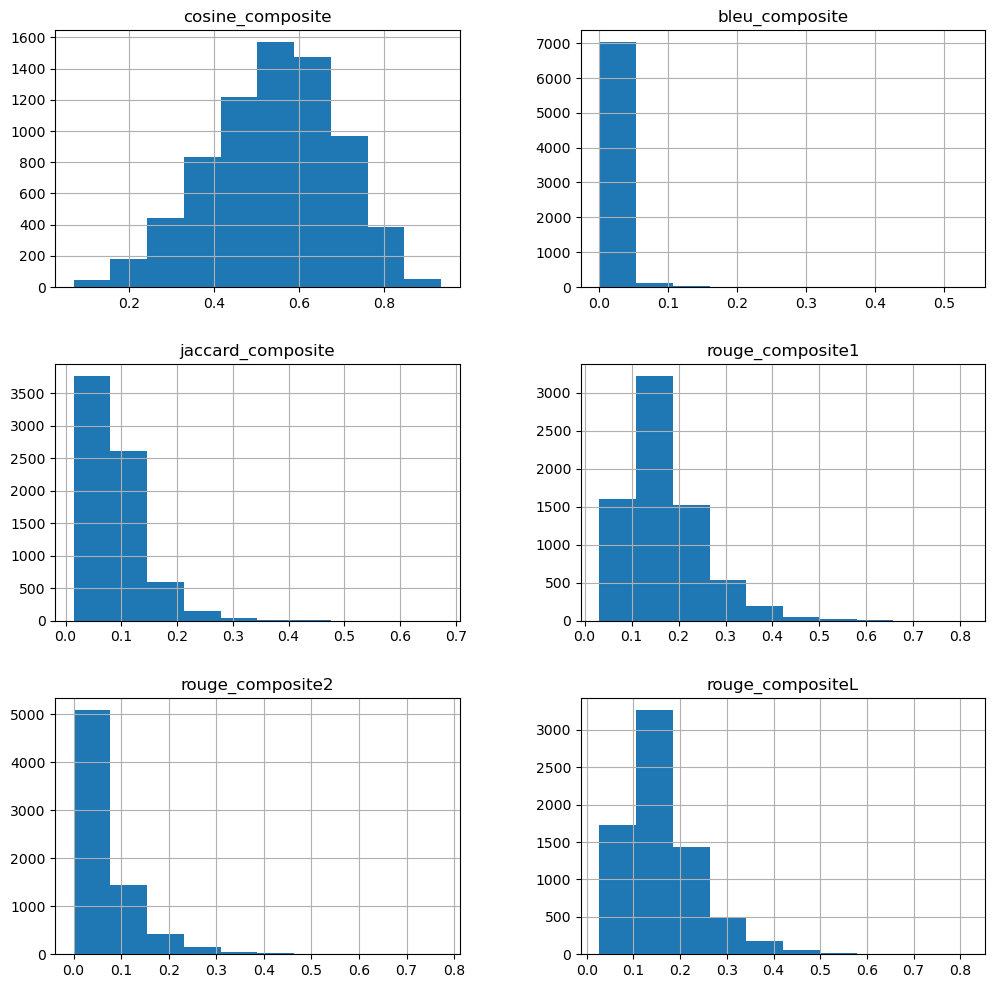

In [24]:
plt.figure(figsize=(15, 8))
df_train_merged[df_train_merged.filter(regex='_composite').columns].hist(figsize=(12, 12))
plt.show()

<Axes: >

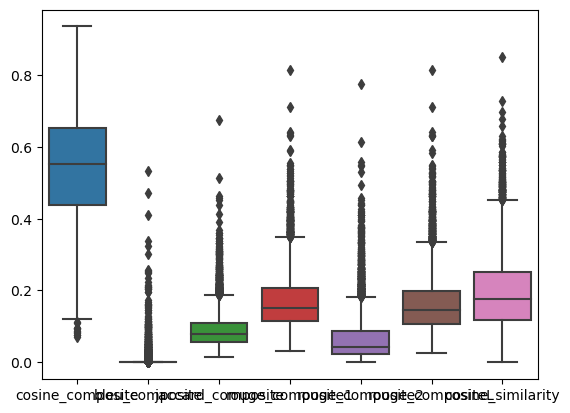

In [25]:
# plt.figure(figsize=(15, 8))
sns.boxplot(data=df_train_merged[list(df_train_merged.filter(regex='_composite').columns) 
                             + ['cosine_similarity']])

<Axes: >

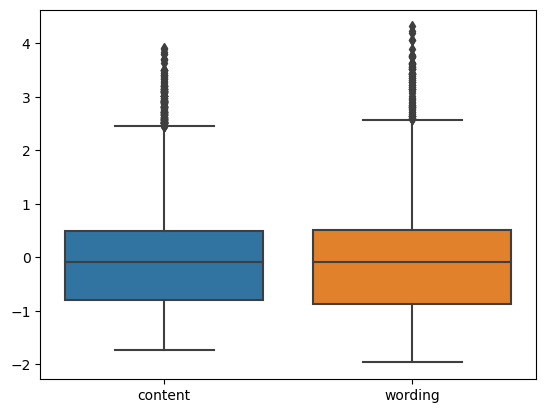

In [26]:
# plt.figure(figsize=(12, 12))
sns.boxplot(data=df_train_merged[['content', 'wording']])

In [27]:
# sns.pairplot(df_train_merged[list(df_train_merged.filter(regex='_composite').columns) 
#                              + ['content', 'wording', 'cosine_similarity']])

In [28]:
import statsmodels.api as sm

X = df_train_merged[['cosine_composite', 'bleu_composite', 'jaccard_composite'
                     , 'rouge_composite1', 'rouge_composite2', 'rouge_compositeL']
                   ]
y = df_train_merged['content']
X = sm.add_constant(X)  # Adds a constant term to the predictor

model = sm.OLS(y, X)
result = model.fit()
print(result.summary())


                            OLS Regression Results                            
Dep. Variable:                content   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     2403.
Date:                Wed, 30 Aug 2023   Prob (F-statistic):               0.00
Time:                        06:10:12   Log-Likelihood:                -6518.7
No. Observations:                7165   AIC:                         1.305e+04
Df Residuals:                    7158   BIC:                         1.310e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -2.9743      0.03

In [29]:
import statsmodels.api as sm

X = df_train_merged[['cosine_composite', 'bleu_composite', 'jaccard_composite'
                     , 'rouge_composite1', 'rouge_composite2', 'rouge_compositeL']
                   ]
y = df_train_merged['wording']
X = sm.add_constant(X)  # Adds a constant term to the predictor

model = sm.OLS(y, X)
result = model.fit()
print(result.summary())


                            OLS Regression Results                            
Dep. Variable:                wording   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     957.5
Date:                Wed, 30 Aug 2023   Prob (F-statistic):               0.00
Time:                        06:10:12   Log-Likelihood:                -8309.0
No. Observations:                7165   AIC:                         1.663e+04
Df Residuals:                    7158   BIC:                         1.668e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -2.5122      0.04

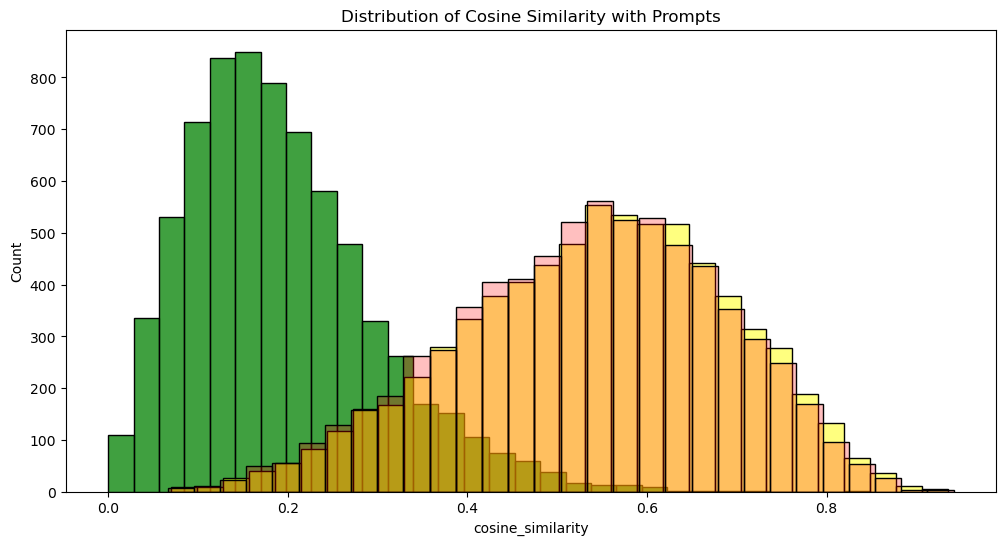

In [30]:
# 4. Distribution of cosine similarity
plt.figure(figsize=(12, 6))
sns.histplot(df_train_merged['cosine_similarity'], bins=30, color='green')
sns.histplot(df_train_merged['cosine_composite'], bins=30, color='yellow',alpha=0.5)
sns.histplot(df_train_merged['cosine_text'], bins=30, color='red',alpha=0.25)
#sns.histplot(df_train_merged['cosine_question'], bins=30, color='blue',alpha=0.25)
#sns.histplot(df_train_merged['cosine_title'], bins=30, color='purple',alpha=0.25)
plt.title('Distribution of Cosine Similarity with Prompts')
plt.show()

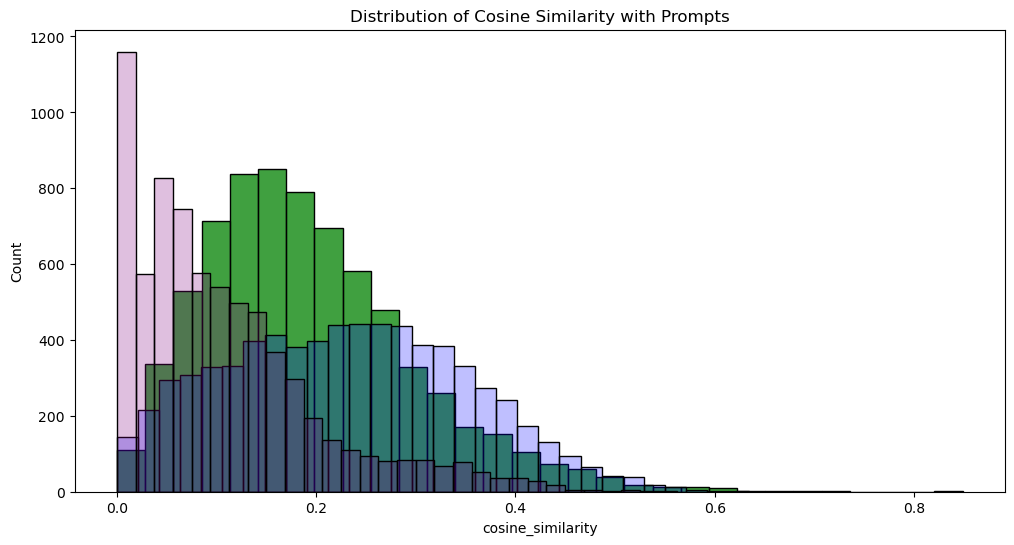

In [31]:
# 4. Distribution of cosine similarity
plt.figure(figsize=(12, 6))
sns.histplot(df_train_merged['cosine_similarity'], bins=30, color='green')
#sns.histplot(df_train_merged['cosine_composite'], bins=30, color='yellow',alpha=0.5)
#sns.histplot(df_train_merged['cosine_text'], bins=30, color='red',alpha=0.25)
sns.histplot(df_train_merged['cosine_question'], bins=30, color='blue',alpha=0.25)
sns.histplot(df_train_merged['cosine_title'], bins=30, color='purple',alpha=0.25)
plt.title('Distribution of Cosine Similarity with Prompts')
plt.show()

In [32]:
df_train_merged.to_csv("df_train_merged.csv")
df_test_merged.to_csv("df_test_merged.csv")

In [33]:
drop_features = ['content', 'wording', 'source']

# Select features that have an absolute correlation of 0.2 oaggr greater with either 'content' or 'wording'
selected_features = correlation_with_target[(correlation_with_target['content'].abs() >= 0.2) | 
                                            (correlation_with_target['wording'].abs() >= 0.2)].index.tolist()

# Exclude the target variables from the selected features
selected_features = [feature for feature in selected_features if feature not in drop_features]

# Create a new DataFrame with only the selected features and target variables
# df_selected = df_train_merged[selected_features + ['content', 'wording']]
df_train_test_selected = df_train_test_merged[selected_features + drop_features]

# Show the first few rows of the new DataFrame
df_train_test_selected.head()


,unique_words,summary_length,num_words,rouge_composite1,rouge_text1,rouge_compositeL,jaccard_composite,rouge_textL,jaccard_text,cosine_composite,cosine_text,cosine_similarity,rouge_composite2,rouge_text2,bleu_text,bleu_composite,cosine_question,cosine_title,bleu_question,content,wording,source
0,51,346,61,0.124646,0.127168,0.124646,0.062130,0.127168,0.063636,0.415563,0.414777,0.089162,0.006579,0.006768,5.508211e-05,3.840429e-05,0.146337,0.211211,0.535069,0.205683,0.380538,train
1,138,1225,203,0.228833,0.227907,0.228833,0.117794,0.227907,0.117347,0.724590,0.714402,0.305167,0.059459,0.058091,2.672422e-02,2.719151e-02,0.374744,0.485318,0.055816,3.272894,3.219757,train
2,50,345,60,0.165242,0.168605,0.148148,0.088146,0.151163,0.090343,0.519201,0.513356,0.282518,0.042904,0.044143,1.966138e-05,1.362614e-05,0.238823,0.303667,0.562341,0.205683,0.380538,train
3,59,451,76,0.227147,0.231638,0.193906,0.108761,0.197740,0.111455,0.685507,0.670896,0.259535,0.067524,0.066116,1.902272e-04,1.485638e-04,0.423614,0.450752,0.078479,0.567975,0.969062,train
4,25,145,27,0.097859,0.093750,0.091743,0.050473,0.087500,0.048387,0.465987,0.450628,0.125462,0.013937,0.014363,3.869070e-10,1.739079e-10,0.283690,0.304930,0.655997,-0.910596,-0.081769,train


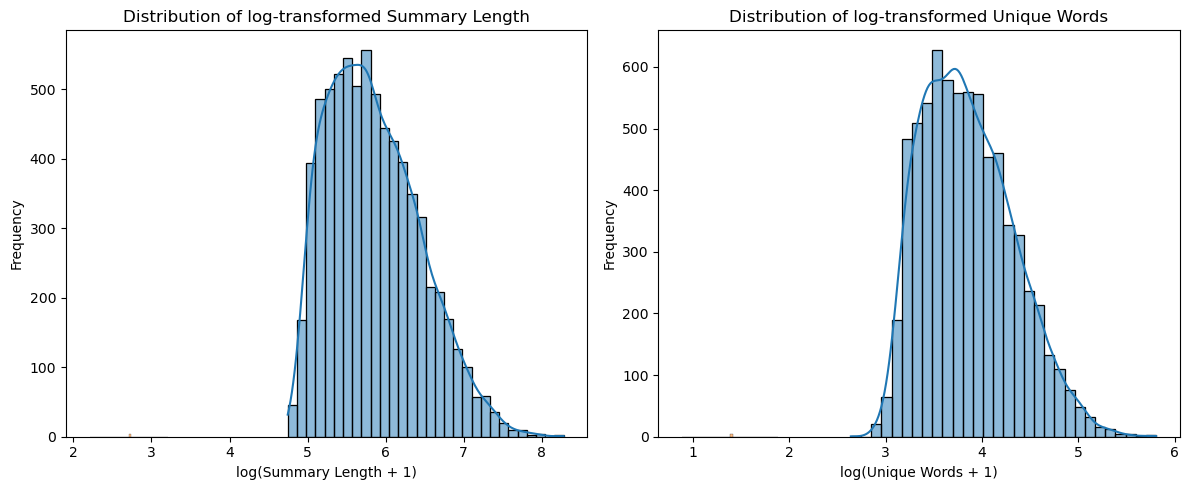

In [34]:
# Apply logarithmic transformation to the skewed features 'summary_length' and 'unique_words'
df_train_test_selected['log_summary_length'] = np.log1p(df_train_test_selected['summary_length'])
df_train_test_selected['log_unique_words'] = np.log1p(df_train_test_selected['unique_words'])

# Drop the original skewed features
df_train_test_selected.drop(['summary_length', 'unique_words'], axis=1, inplace=True)

# Visualize the distributions of the transformed features
plt.figure(figsize=(12, 5))

# Plot for log-transformed summary_length
plt.subplot(1, 2, 1)
sns.histplot(df_train_test_selected[df_train_test_selected['source'] == 'train']['log_summary_length'], kde=True, bins=30)
sns.histplot(df_train_test_selected[df_train_test_selected['source'] == 'test']['log_summary_length'], kde=True, bins=30)
plt.title('Distribution of log-transformed Summary Length')
plt.xlabel('log(Summary Length + 1)')
plt.ylabel('Frequency')

# Plot for log-transformed unique_words
plt.subplot(1, 2, 2)
sns.histplot(df_train_test_selected[df_train_test_selected['source'] == 'train']['log_unique_words'], kde=True, bins=30)
sns.histplot(df_train_test_selected[df_train_test_selected['source'] == 'test']['log_unique_words'], kde=True, bins=30)
plt.title('Distribution of log-transformed Unique Words')
plt.xlabel('log(Unique Words + 1)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [35]:
from sklearn.preprocessing import StandardScaler

df_train_merged_selected = df_train_test_selected[df_train_test_selected['source'] == 'train']
df_test_merged_selected = df_train_test_selected[df_train_test_selected['source'] == 'test']

# Initialize the StandardScaler
scaler = StandardScaler()

# Scale the features
train_scaled_features = scaler.fit_transform(df_train_merged_selected.drop(drop_features, axis=1))
test_scaled_features = scaler.fit_transform(df_test_merged_selected.drop(drop_features, axis=1))

# Create a DataFrame for the scaled features
#train
df_train_merged_scaled = pd.DataFrame(train_scaled_features, columns=
                                    df_train_merged_selected.drop(drop_features
                                                                , axis=1).columns)
#test
df_test_merged_scaled = pd.DataFrame(test_scaled_features, columns=
                                    df_test_merged_selected.drop(drop_features
                                                                , axis=1).columns)

# Add the target variables back to the DataFrame
df_train_merged_scaled['content'] = df_train_merged_selected['content']
df_train_merged_scaled['wording'] = df_train_merged_selected['wording']

df_test_merged_scaled['content'] = df_test_merged_selected['content']
df_test_merged_scaled['wording'] = df_test_merged_selected['wording']

# Show the first few rows of the scaled DataFrame
# df_train_test_scaled.head()

# df_train_merged_scaled = df_train_test_scaled[df_train_test_scaled['source'] == 'train']
# df_test_merged_scaled = df_train_test_scaled[df_train_test_scaled['source'] == 'test']

In [36]:
from sklearn.model_selection import train_test_split

drop_features =['wording','content']
# Define features (X) and target variables (y_content and y_wording)
X = df_train_merged_scaled.drop(drop_features, axis=1)
y_content = df_train_merged_scaled['content']
y_wording = df_train_merged_scaled['wording']

# Split the data into training and testing sets for both target variables
X_train_content, X_test_content, y_train_content, y_test_content = train_test_split(X, y_content, test_size=0.2, random_state=42)
X_train_wording, X_test_wording, y_train_wording, y_test_wording = train_test_split(X, y_wording, test_size=0.2, random_state=42)

# Show the shape of the training and testing sets
(X_train_content.shape, X_test_content.shape), (X_train_wording.shape, X_test_wording.shape)


(((5732, 19), (1433, 19)), ((5732, 19), (1433, 19)))

In [37]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import time

# Initialize the Random Forest Regressor for 'content'
rf_content = RandomForestRegressor(n_estimators=100, random_state=42)

# Record the start time for training
start_time_content = time.time()

# Train the model on the training set for 'content'
rf_content.fit(X_train_content, y_train_content)

# Record the end time for training
end_time_content = time.time()

# Calculate the time taken for training
time_taken_content = end_time_content - start_time_content

# Predict the 'content' scores on the test set
y_pred_content = rf_content.predict(X_test_content)

# Calculate evaluation metrics for the 'content' model
rmse_content = mean_squared_error(y_test_content, y_pred_content, squared=False)
r2_content = r2_score(y_test_content, y_pred_content)

time_taken_content, rmse_content, r2_content


(8.786567211151123, 0.4512023536832204, 0.8120006477227458)

In [38]:
# Initialize the Random Forest Regressor for 'wording'
rf_wording = RandomForestRegressor(n_estimators=100, random_state=42)

# Record the start time for training
start_time_wording = time.time()

# Train the model on the training set for 'wording'
rf_wording.fit(X_train_wording, y_train_wording)

# Record the end time for training
end_time_wording = time.time()

# Calculate the time taken for training
time_taken_wording = end_time_wording - start_time_wording

# Predict the 'wording' scores on the test set
y_pred_wording = rf_wording.predict(X_test_wording)

# Calculate evaluation metrics for the 'wording' model
rmse_wording = mean_squared_error(y_test_wording, y_pred_wording, squared=False)
r2_wording = r2_score(y_test_wording, y_pred_wording)

time_taken_wording, rmse_wording, r2_wording


(8.658206939697266, 0.6170836434570669, 0.6258079720274754)

In [39]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define features (X) and target variables (y_content and y_wording)
X = df_train_merged_scaled.drop(drop_features, axis=1)
y_content = df_train_merged_scaled['content']
y_wording = df_train_merged_scaled['wording']

# Split the data into training and testing sets for both target variables
X_train_content, X_test_content, y_train_content, y_test_content = train_test_split(X, y_content, test_size=0.2, random_state=42)
X_train_wording, X_test_wording, y_train_wording, y_test_wording = train_test_split(X, y_wording, test_size=0.2, random_state=42)

# Initialize Random Forest Regressors
rf_content = RandomForestRegressor(random_state=42)
rf_wording = RandomForestRegressor(random_state=42)

# Define hyperparameters to tune
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, 30]
}

# GridSearchCV for content
grid_search_content = GridSearchCV(estimator=rf_content, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='r2')
grid_search_content.fit(X_train_content, y_train_content)
best_params_content = grid_search_content.best_params_

# GridSearchCV for wording
grid_search_wording = GridSearchCV(estimator=rf_wording, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='r2')
grid_search_wording.fit(X_train_wording, y_train_wording)
best_params_wording = grid_search_wording.best_params_

print("Best Parameters for Content:", best_params_content)
print("Best Parameters for Wording:", best_params_wording)


Fitting 3 folds for each of 9 candidates, totalling 27 fits


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Parameters for Content: {'max_depth': 10, 'n_estimators': 150}
Best Parameters for Wording: {'max_depth': 10, 'n_estimators': 150}


In [40]:
# Initialize the optimized Random Forest Regressor for 'content' with the best parameters
rf_content_optimized = RandomForestRegressor(n_estimators=150, max_depth=20, random_state=42)

# Train the optimized model on the training set for 'content'
rf_content_optimized.fit(X_train_content, y_train_content)

# Predict the 'content' scores on the test set
y_pred_content_optimized = rf_content_optimized.predict(X_test_content)

# Calculate evaluation metrics for the optimized 'content' model
rmse_content_optimized = mean_squared_error(y_test_content, y_pred_content_optimized, squared=False)
r2_content_optimized = r2_score(y_test_content, y_pred_content_optimized)

# rmse_content_optimized, r2_content_optimized

print("RMSE for content (Optimized):", rmse_content_optimized)
print("R-Squared for content (Optimized):", r2_content_optimized)


RMSE for content (Optimized): 0.45173457758879537
R-Squared for content (Optimized): 0.8115568700643967


In [41]:
print(X_train_content.shape)
print(X_test_content.shape)
print(y_content.shape)

(5732, 19)
(1433, 19)
(7165,)


In [42]:
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the optimized Random Forest Regressor for 'wording' with the best parameters
rf_wording_optimized = RandomForestRegressor(n_estimators=150, max_depth=10, random_state=42)

# Train the optimized model on the training set for 'wording'
rf_wording_optimized.fit(X_train_wording, y_train_wording)

# Predict the 'wording' scores on the test set
y_pred_wording_optimized = rf_wording_optimized.predict(X_test_wording)

# Calculate evaluation metrics for the optimized 'wording' model
rmse_wording_optimized = mean_squared_error(y_test_wording, y_pred_wording_optimized, squared=False)
r2_wording_optimized = r2_score(y_test_wording, y_pred_wording_optimized)

print("RMSE for Wording (Optimized):", rmse_wording_optimized)
print("R-Squared for Wording (Optimized):", r2_wording_optimized)


RMSE for Wording (Optimized): 0.6083927753257126
R-Squared for Wording (Optimized): 0.636273823803917


In [43]:
# Calculate MCRMSE (Mean Columnwise Root Mean Squared Error)
mcrmse = (rmse_content_optimized + rmse_wording_optimized) / 2
print("mcrmse: ", mcrmse)

mcrmse:  0.5300636764572539


In [44]:
df_test_merged_scaled

# Make predictions using the optimized models
df_test['content'] = rf_content_optimized.predict(df_test_merged_scaled.drop(drop_features, axis=1))
df_test['wording'] = rf_wording_optimized.predict(df_test_merged_scaled.drop(drop_features, axis=1))

# Create the submission file
submission = df_test[['student_id', 'content', 'wording']]
submission.to_csv('submission.csv', index=False)